# PanCancer NF1 mutation classifier using TCGA RNA-seq data with logistic and XGBoost classifier 

NF1 gene encodes neurofibromin that helps regulate cell growth. Its mutation causes a loss of neurofibromin, which allows cells to grow uncontrolled.

In [350]:
import os
import sys
import warnings

import pandas as pd
import csv
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, cross_val_predict
from dask_ml.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve,precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from statsmodels.robust.scale import mad

In [351]:
alphas=[0.1,0.13,0.15,0.18,0.2,0.25,0.3]
l1_ratios=[0.15,0.155,0.16,0.2,0.25,0.3,0.4]
nf1_diseases='BLCA,COAD,GBM,LGG,LUAD,LUSC,OV,PCPG,SARC,SKCM,STAD,UCEC'
genes='NF1'
diseases=nf1_diseases.split(',')
#also test the classifier with testing data with shuffled gene names as the baseline
shuffled=True
#the top n variable genes will be used for classification
num_features_kept=8000
folds=5

In [352]:
#gene expression file
expr_file = os.path.join('data', 'pancan_rnaseq_freeze.tsv.gz')
#gene mutation file
mut_file = os.path.join('data', 'pancan_mutation_freeze.tsv.gz')
#mutation burden
mut_burden_file = os.path.join('data', 'mutation_burden_freeze.tsv')
#information (ID, cancer types etc.) for each sample
sample_freeze_file = os.path.join('data', 'sample_freeze.tsv')
#CNV file
copy_loss_file = os.path.join('data', 'copy_number_loss_status.tsv.gz')
copy_gain_file = os.path.join('data', 'copy_number_gain_status.tsv.gz')
    
rnaseq_full_df = pd.read_table(expr_file, index_col=0)
mutation_df = pd.read_table(mut_file, index_col=0)
sample_freeze = pd.read_table(sample_freeze_file, index_col=0)
mut_burden = pd.read_table(mut_burden_file)
copy_loss_df = pd.read_table(copy_loss_file, index_col=0)
copy_gain_df = pd.read_table(copy_gain_file, index_col=0)

In [353]:
def get_threshold_metrics(y_true, y_pred, drop_intermediate=True,
                          disease='all'):
    """
    Retrieve true/false positive rates and auroc/aupr for class predictions

    Arguments:
    y_true - an array of gold standard mutation status
    y_pred - an array of predicted mutation status
    disease - a string that includes the corresponding TCGA study acronym

    Output:
    dict of AUROC, AUPR, pandas dataframes of ROC and PR data, and cancer-type
    """
    import pandas as pd
    from sklearn.metrics import roc_auc_score, roc_curve
    from sklearn.metrics import precision_recall_curve, average_precision_score

    roc_columns = ['fpr', 'tpr', 'threshold']
    pr_columns = ['precision', 'recall', 'threshold']

    if drop_intermediate:
        roc_items = zip(roc_columns,
                        roc_curve(y_true, y_pred, drop_intermediate=False))
    else:
        roc_items = zip(roc_columns, roc_curve(y_true, y_pred))

    roc_df = pd.DataFrame.from_dict(dict(roc_items))

    prec, rec, thresh = precision_recall_curve(y_true, y_pred)
    pr_df = pd.DataFrame.from_records([prec, rec]).T
    pr_df = pd.concat([pr_df, pd.Series(thresh)], ignore_index=True, axis=1)
    pr_df.columns = pr_columns

    auroc = roc_auc_score(y_true, y_pred, average='weighted')
    aupr = average_precision_score(y_true, y_pred, average='weighted')

    return {'auroc': auroc, 'aupr': aupr, 'roc_df': roc_df,
            'pr_df': pr_df, 'disease': disease}

def shuffle_columns(gene):
    """
    To be used in an `apply` pandas func to shuffle columns around a datafame
    Import only
    """
    import numpy as np
    return np.random.permutation(gene.tolist())

## Check NF1 mutation and copy number loss rate for each cancer type

In [354]:
mutation_df

,5S_rRNA,A1BG,A1CF,A2M,A2ML1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,ZYX,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-150,hsa-mir-3171,hsa-mir-466,hsa-mir-5195,hsa-mir-6080,hsa-mir-7162
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0047-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-0055-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2483-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2485-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-02-2486-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-ZS-A9CF-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-ZS-A9CG-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TCGA-ZT-A8OM-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [355]:
mutation_nf1=mutation_df.loc[:,['NF1']]
sample_freeze_nf1=sample_freeze.loc[:,['SAMPLE_BARCODE','DISEASE']]
sample_freeze_nf1=sample_freeze_nf1.set_index('SAMPLE_BARCODE')
mutation_nf1=mutation_nf1.merge(sample_freeze_nf1, left_index=True, right_index=True)
#NF1 mutant numbers for each disease
mutation_nf1=mutation_nf1.groupby(['DISEASE'])['NF1'].value_counts().unstack().fillna(0)
mutation_nf1_rate=mutation_nf1.iloc[:,1]/mutation_nf1.sum(axis=1)

In [356]:
copy_loss_df_nf1=copy_loss_df.loc[:,['NF1']]
copy_loss_df_nf1=copy_loss_df_nf1.merge(sample_freeze_nf1, left_index=True, right_index=True)
#NF1 gene loss for each disease
copy_loss_df_nf1=copy_loss_df_nf1.groupby(['DISEASE'])['NF1'].value_counts().unstack().fillna(0)
copy_loss_df_nf1_rate=copy_loss_df_nf1.iloc[:,1]/copy_loss_df_nf1.sum(axis=1)

In [357]:
nf1_mutate_rate = pd.concat([mutation_nf1_rate,copy_loss_df_nf1_rate], keys=['mutation', 'copy_num'],axis=1)
nf1_mutate_rate

,mutation,copy_num
DISEASE,,
ACC,0.052632,0.026316
BLCA,0.077889,0.005025
BRCA,0.037717,0.006116
CESC,0.036765,0.007353
CHOL,0.000000,0.000000
COAD,0.061584,0.005865
DLBC,0.054054,0.000000
ESCA,0.023669,0.005917
GBM,0.120968,0.008065


## Prepare the matrix y for training, 1 stands for NF1 mutation and loss, 0 stands for normal NF1

In [358]:
y_mutation=mutation_df.loc[:,['NF1']]
y_copyn=copy_loss_df.loc[:,['NF1']]
y_raw=y_mutation.merge(y_copyn, left_index=True, right_index=True)
y_raw=y_raw.assign(total_status=y_raw.max(axis=1))
y_raw=y_raw.merge(sample_freeze_nf1, left_index=True, right_index=True)

In [359]:
y_raw

,NF1_x,NF1_y,total_status,DISEASE
SAMPLE_BARCODE,,,,
TCGA-02-0047-01,0,0,0,GBM
TCGA-02-0055-01,0,1,1,GBM
TCGA-02-2483-01,0,0,0,GBM
TCGA-02-2485-01,0,0,0,GBM
TCGA-02-2486-01,0,0,0,GBM
...,...,...,...,...
TCGA-ZS-A9CF-01,0,0,0,LIHC
TCGA-ZS-A9CG-01,0,0,0,LIHC
TCGA-ZT-A8OM-01,0,0,0,THYM


In [360]:
y_raw=y_raw.loc[y_raw.DISEASE.isin(diseases)]
y=y_raw.loc[:,'total_status']

In [361]:
y

SAMPLE_BARCODE
TCGA-02-0047-01    0
TCGA-02-0055-01    1
TCGA-02-2483-01    0
TCGA-02-2485-01    0
TCGA-02-2486-01    0
                  ..
TCGA-ZF-AA58-01    0
TCGA-ZF-AA5H-01    0
TCGA-ZF-AA5N-01    0
TCGA-ZF-AA5P-01    0
TCGA-ZQ-A9CR-01    0
Name: total_status, Length: 4155, dtype: int64

## Prepare the x matrix for training, use gene expression, cancer type and mutation burden as features

In [362]:
mut_burden

,SAMPLE_BARCODE,log10_mut
0,TCGA-02-0047-01,1.812913
1,TCGA-02-0055-01,1.707570
2,TCGA-02-2483-01,1.662758
3,TCGA-02-2485-01,1.748188
4,TCGA-02-2486-01,1.755875
...,...,...
9069,TCGA-ZS-A9CF-01,1.924279
9070,TCGA-ZS-A9CG-01,1.869232
9071,TCGA-ZT-A8OM-01,1.342423
9072,TCGA-ZU-A8S4-01,1.982271


In [363]:
#dummy encoding of cancer type for each sample
disease_dummy=pd.get_dummies(sample_freeze_nf1['DISEASE']).astype(int)
mut_burden=mut_burden.set_index('SAMPLE_BARCODE')
cov_nf1=disease_dummy.merge(mut_burden,left_index=True,right_on='SAMPLE_BARCODE')
cov_nf1

,ACC,BLCA,BRCA,CESC,CHOL,COAD,DLBC,ESCA,GBM,HNSC,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,log10_mut
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.361728
TCGA-OR-A5J2-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.462398
TCGA-OR-A5J3-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.000000
TCGA-OR-A5J5-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.551450
TCGA-OR-A5J6-01,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.462398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-YZ-A980-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.903090
TCGA-YZ-A982-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.342423
TCGA-YZ-A983-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1.230449


In [364]:
#mean absolute deviation for gene expression
gene_mad=x.mad(axis=0)
gene_mad=gene_mad.sort_values(ascending=False)[0:num_features_kept]

In [365]:
#standardize gene expression levels
x_raw = StandardScaler().fit(rnaseq_full_df)
x_scaled = pd.DataFrame(x_raw.transform(rnaseq_full_df),
                           columns=rnaseq_full_df.columns)
x_scaled.index = rnaseq_full_df.index
x=x_scaled.loc[x_scaled.index.isin(y.index),x_scaled.columns.isin(gene_mad.index)]

In [366]:
x=x.merge(cov_nf1,left_index=True,right_on='SAMPLE_BARCODE')

In [367]:
strat=y_raw.loc[:,'DISEASE']

## Build classifier pipeline

In [368]:
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.1,
                                                    random_state=0,
                                                    stratify=strat)

In [369]:
x_train

,A4GALT,AAAS,AAGAB,AAMP,AARS,AASDH,AASDHPPT,AATK,ABAT,ABCA1,...,SARC,SKCM,STAD,TGCT,THCA,THYM,UCEC,UCS,UVM,log10_mut
SAMPLE_BARCODE,,,,,,,,,,,,,,,,,,,,,
TCGA-AA-3492-01,-0.674833,0.286157,1.301824,1.270533,-0.126962,-0.525989,-0.246112,0.106051,-0.458061,-1.038566,...,0,0,0,0,0,0,0,0,0,3.310268
TCGA-92-7340-01,0.753227,-0.483648,0.454445,-1.304241,-0.199141,4.043221,-0.571977,-0.408341,-0.478358,0.062502,...,0,0,0,0,0,0,0,0,0,2.871573
TCGA-XF-AAN0-01,1.386312,-1.093087,1.314840,0.290231,-0.978904,-1.220558,-0.868375,-0.402808,-0.474206,0.224480,...,0,0,0,0,0,0,0,0,0,2.587711
TCGA-D9-A6EG-06,-0.738299,-1.125962,0.188092,-0.039149,0.730080,0.607933,-0.488835,0.934623,-0.515601,0.051720,...,0,1,0,0,0,0,0,0,0,1.832509
TCGA-DB-5279-01,-0.716116,-1.146771,-1.182113,1.551697,3.170342,0.717439,2.126390,0.745762,3.841279,0.734128,...,0,0,0,0,0,0,0,0,0,1.568202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAMJ-01,0.349458,-0.739473,0.132078,0.299116,-0.708092,-0.869973,-0.282118,-0.340481,-0.166913,1.015597,...,0,0,0,0,0,0,0,0,0,1.602060
TCGA-A6-6651-01,-0.117510,0.453044,-0.621509,0.480363,-0.028998,-0.540703,-0.675558,0.174669,-0.328469,-0.030766,...,0,0,0,0,0,0,0,0,0,1.934498
TCGA-DM-A28K-01,-0.688446,0.183426,0.345328,0.494309,-0.790906,-0.332545,-0.586337,-0.392597,-0.512678,-1.062724,...,0,0,0,0,0,0,0,0,0,2.008600


In [370]:
y_train

SAMPLE_BARCODE
TCGA-AA-3492-01    0
TCGA-92-7340-01    0
TCGA-XF-AAN0-01    0
TCGA-D9-A6EG-06    0
TCGA-DB-5279-01    0
                  ..
TCGA-XF-AAMJ-01    0
TCGA-A6-6651-01    0
TCGA-DM-A28K-01    0
TCGA-QQ-A5VA-01    0
TCGA-AA-A02E-01    0
Name: total_status, Length: 3739, dtype: int64

### Logistic regression models with elastic net regularization

In [371]:
clf_parameters = {'alpha': alphas, 'l1_ratio': l1_ratios}

In [372]:
#Use stochastic gradient descent to reduce loss function
estimator = SGDClassifier(random_state=0,penalty='elasticnet',
                          class_weight='balanced',loss='log',max_iter=5,tol=None)

In [373]:
cv_pipeline = GridSearchCV(estimator=estimator, param_grid=clf_parameters,
                           n_jobs=-1, cv=folds, scoring='roc_auc',
                           return_train_score=True)

In [374]:
cv_pipeline.fit(X=x_train, y=y_train)


GridSearchCV(cv=5,
             estimator=SGDClassifier(class_weight='balanced', loss='log',
                                     max_iter=5, penalty='elasticnet',
                                     random_state=0, tol=None),
             param_grid={'alpha': [0.1, 0.13, 0.15, 0.18, 0.2, 0.25, 0.3],
                         'l1_ratio': [0.15, 0.155, 0.16, 0.2, 0.25, 0.3, 0.4]},
             return_train_score=True, scoring='roc_auc')

In [375]:
cv_results = pd.concat([pd.DataFrame(cv_pipeline.cv_results_)
                          .drop('params', axis=1),
                        pd.DataFrame.from_records(cv_pipeline
                                                  .cv_results_['params'])],
                       axis=1)

In [376]:
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='l1_ratio',
                              columns='alpha')

Text(33.0, 0.5, 'Elastic net mixing parameter (l1_ratio)')

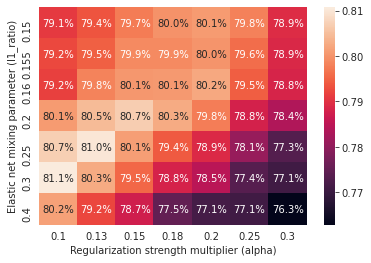

In [377]:
# Cross-validated performance heatmap
cv_score_mat = pd.pivot_table(cv_results, values='mean_test_score',
                              index='l1_ratio',
                              columns='alpha')
ax = sns.heatmap(cv_score_mat, annot=True, fmt='.1%')
ax.set_xlabel('Regularization strength multiplier (alpha)')
ax.set_ylabel('Elastic net mixing parameter (l1_ratio)')

In [378]:
cv_pipeline.best_params_

{'alpha': 0.1, 'l1_ratio': 0.3}

In [381]:
# Get predictions
y_predict_train = cv_pipeline.decision_function(x_train)
y_predict_test = cv_pipeline.decision_function(x_test)
metrics_train = get_threshold_metrics(y_train, y_predict_train)
metrics_test = get_threshold_metrics(y_test, y_predict_test)

In [383]:
y_cv = cross_val_predict(cv_pipeline.best_estimator_, X=x_train, y=y_train,
                         cv=folds, method='decision_function')
metrics_cv = get_threshold_metrics(y_train, y_cv)

In [384]:
x_train.shape

(3739, 8034)

In [385]:
# Determine shuffled predictive ability of shuffled gene expression matrix
# representing a test of inflation of ROC metrics. Be sure to only shuffle
# gene names, retain covariate information (tissue type and log10 mutations)
if shuffled:
    # Shuffle genes
    x_train_genes = x_train.iloc[:, range(num_features_kept)]
    rnaseq_shuffled_df = x_train_genes.apply(shuffle_columns, axis=1,
                                             result_type='broadcast')

    x_train_cov = x_train.iloc[:, num_features_kept:]
    rnaseq_shuffled_df = pd.concat([rnaseq_shuffled_df, x_train_cov], axis=1)

    y_predict_shuffled = cv_pipeline.decision_function(rnaseq_shuffled_df)
    metrics_shuffled = get_threshold_metrics(y_train, y_predict_shuffled)

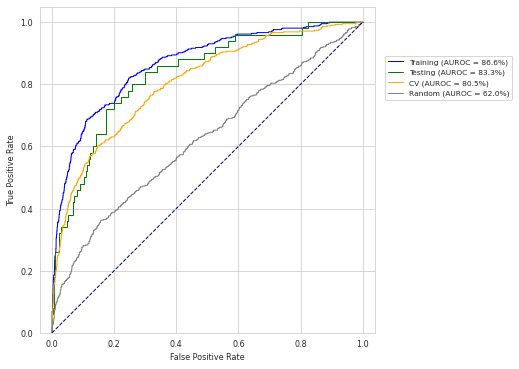

In [386]:
# Plot ROC
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
total_auroc = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]
if shuffled:
    metrics_list += [('Random', metrics_shuffled)]

for label, metrics in metrics_list:

    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
             label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']),
             linewidth=1, c=colors[idx])
    total_auroc[label] = metrics['auroc']
    idx += 1

plt.axis('equal')
plt.plot([0, 1], [0, 1], color='navy', linewidth=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

In [387]:
total_auroc

{'Training': 0.8657904501203373,
 'Testing': 0.8325136612021857,
 'CV': 0.8051425205410627,
 'Random': 0.6195554092547756}

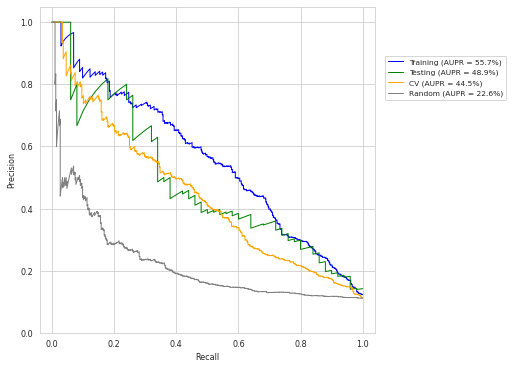

In [388]:
# Plot PR
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
total_aupr = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]
if shuffled:
    metrics_list += [('Random', metrics_shuffled)]

for label, metrics in metrics_list:
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
             label='{} (AUPR = {:.1%})'.format(label, metrics['aupr']),
             linewidth=1, c=colors[idx])
    total_aupr[label] = metrics['aupr']
    idx += 1

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

### XGBoost

In [389]:
#First use a high learning rate to find a rough number of gradient boosted trees
xgb1 = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=0)

xgb1.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='logloss',
        early_stopping_rounds=50,
        verbose=True)

evals_result = xgb1.evals_result()


[0]	validation_0-logloss:0.62099	validation_1-logloss:0.62943
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.56495	validation_1-logloss:0.57985
[2]	validation_0-logloss:0.51497	validation_1-logloss:0.53763
[3]	validation_0-logloss:0.47086	validation_1-logloss:0.49861
[4]	validation_0-logloss:0.43366	validation_1-logloss:0.46721
[5]	validation_0-logloss:0.40367	validation_1-logloss:0.44141
[6]	validation_0-logloss:0.37514	validation_1-logloss:0.41960
[7]	validation_0-logloss:0.34887	validation_1-logloss:0.39814
[8]	validation_0-logloss:0.32962	validation_1-logloss:0.38420
[9]	validation_0-logloss:0.31394	validation_1-logloss:0.37257
[10]	validation_0-logloss:0.29517	validation_1-logloss:0.35926
[11]	validation_0-logloss:0.28079	validation_1-logloss:0.35100
[12]	validation_0-logloss:0.26569	validation_1-logloss:0.34080
[13]	validation_0-logloss:

In [390]:
#Optimize for maximum tree depth and minimum sum of instance weight needed in a child.
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=60, gamma=0, subsample=0.8,colsample_bytree=0.8,
 objective= 'binary:logistic', scale_pos_weight=1, seed=0), 
 param_grid = param_test1,     scoring='roc_auc',iid=False, cv=5)
gsearch1.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, gamma=0, gpu_id=None,
                                     importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.1, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=60, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=1, seed=0, subsample=0.8,
                                     tree_method=None, v

In [391]:
gsearch1.best_params_,     gsearch1.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.8553405719080688)

In [392]:
#optimize for gamma (Minimum loss reduction required to make a further partition on a leaf node of the tree)
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch2= GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=60, subsample=0.8,colsample_bytree=0.8,
                                                     max_depth=3, min_child_weight=3,objective= 'binary:logistic', scale_pos_weight=1, seed=0), 
                       param_grid = param_test2,     scoring='roc_auc',iid=False, cv=5)
gsearch2.fit(x_train, y_train)
gsearch2.best_params_,     gsearch2.best_score_

({'gamma': 0.2}, 0.8573074756676856)

In [393]:
xgb2 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=0)

xgb2.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='logloss',
        early_stopping_rounds=50,
        verbose=True)

[0]	validation_0-logloss:0.68598	validation_1-logloss:0.68642
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.67936	validation_1-logloss:0.68018
[2]	validation_0-logloss:0.67257	validation_1-logloss:0.67398
[3]	validation_0-logloss:0.66581	validation_1-logloss:0.66762
[4]	validation_0-logloss:0.65923	validation_1-logloss:0.66142
[5]	validation_0-logloss:0.65302	validation_1-logloss:0.65554
[6]	validation_0-logloss:0.64680	validation_1-logloss:0.64986
[7]	validation_0-logloss:0.64046	validation_1-logloss:0.64394
[8]	validation_0-logloss:0.63507	validation_1-logloss:0.63888
[9]	validation_0-logloss:0.62983	validation_1-logloss:0.63398
[10]	validation_0-logloss:0.62382	validation_1-logloss:0.62841
[11]	validation_0-logloss:0.61876	validation_1-logloss:0.62360
[12]	validation_0-logloss:0.61315	validation_1-logloss:0.61841
[13]	validation_0-logloss:

[128]	validation_0-logloss:0.30441	validation_1-logloss:0.34635
[129]	validation_0-logloss:0.30319	validation_1-logloss:0.34539
[130]	validation_0-logloss:0.30207	validation_1-logloss:0.34464
[131]	validation_0-logloss:0.30094	validation_1-logloss:0.34378
[132]	validation_0-logloss:0.29974	validation_1-logloss:0.34301
[133]	validation_0-logloss:0.29866	validation_1-logloss:0.34213
[134]	validation_0-logloss:0.29760	validation_1-logloss:0.34132
[135]	validation_0-logloss:0.29663	validation_1-logloss:0.34067
[136]	validation_0-logloss:0.29559	validation_1-logloss:0.33979
[137]	validation_0-logloss:0.29448	validation_1-logloss:0.33903
[138]	validation_0-logloss:0.29338	validation_1-logloss:0.33819
[139]	validation_0-logloss:0.29244	validation_1-logloss:0.33742
[140]	validation_0-logloss:0.29136	validation_1-logloss:0.33668
[141]	validation_0-logloss:0.29027	validation_1-logloss:0.33595
[142]	validation_0-logloss:0.28928	validation_1-logloss:0.33524
[143]	validation_0-logloss:0.28837	valid

[257]	validation_0-logloss:0.21840	validation_1-logloss:0.28767
[258]	validation_0-logloss:0.21808	validation_1-logloss:0.28741
[259]	validation_0-logloss:0.21767	validation_1-logloss:0.28724
[260]	validation_0-logloss:0.21733	validation_1-logloss:0.28697
[261]	validation_0-logloss:0.21693	validation_1-logloss:0.28678
[262]	validation_0-logloss:0.21655	validation_1-logloss:0.28663
[263]	validation_0-logloss:0.21634	validation_1-logloss:0.28643
[264]	validation_0-logloss:0.21597	validation_1-logloss:0.28631
[265]	validation_0-logloss:0.21565	validation_1-logloss:0.28610
[266]	validation_0-logloss:0.21528	validation_1-logloss:0.28584
[267]	validation_0-logloss:0.21490	validation_1-logloss:0.28569
[268]	validation_0-logloss:0.21453	validation_1-logloss:0.28558
[269]	validation_0-logloss:0.21418	validation_1-logloss:0.28539
[270]	validation_0-logloss:0.21383	validation_1-logloss:0.28522
[271]	validation_0-logloss:0.21351	validation_1-logloss:0.28498
[272]	validation_0-logloss:0.21321	valid

[386]	validation_0-logloss:0.18270	validation_1-logloss:0.27414
[387]	validation_0-logloss:0.18253	validation_1-logloss:0.27409
[388]	validation_0-logloss:0.18244	validation_1-logloss:0.27403
[389]	validation_0-logloss:0.18218	validation_1-logloss:0.27412
[390]	validation_0-logloss:0.18199	validation_1-logloss:0.27409
[391]	validation_0-logloss:0.18181	validation_1-logloss:0.27414
[392]	validation_0-logloss:0.18163	validation_1-logloss:0.27408
[393]	validation_0-logloss:0.18144	validation_1-logloss:0.27398
[394]	validation_0-logloss:0.18122	validation_1-logloss:0.27394
[395]	validation_0-logloss:0.18103	validation_1-logloss:0.27394
[396]	validation_0-logloss:0.18082	validation_1-logloss:0.27401
[397]	validation_0-logloss:0.18058	validation_1-logloss:0.27397
[398]	validation_0-logloss:0.18033	validation_1-logloss:0.27389
[399]	validation_0-logloss:0.18010	validation_1-logloss:0.27391
[400]	validation_0-logloss:0.17985	validation_1-logloss:0.27374
[401]	validation_0-logloss:0.17968	valid

[515]	validation_0-logloss:0.15785	validation_1-logloss:0.27284
[516]	validation_0-logloss:0.15766	validation_1-logloss:0.27285
[517]	validation_0-logloss:0.15749	validation_1-logloss:0.27282
[518]	validation_0-logloss:0.15734	validation_1-logloss:0.27282
[519]	validation_0-logloss:0.15716	validation_1-logloss:0.27286
[520]	validation_0-logloss:0.15706	validation_1-logloss:0.27276
[521]	validation_0-logloss:0.15689	validation_1-logloss:0.27274
[522]	validation_0-logloss:0.15676	validation_1-logloss:0.27276
[523]	validation_0-logloss:0.15663	validation_1-logloss:0.27271
[524]	validation_0-logloss:0.15644	validation_1-logloss:0.27276
[525]	validation_0-logloss:0.15632	validation_1-logloss:0.27273
[526]	validation_0-logloss:0.15614	validation_1-logloss:0.27268
[527]	validation_0-logloss:0.15599	validation_1-logloss:0.27253
[528]	validation_0-logloss:0.15586	validation_1-logloss:0.27259
[529]	validation_0-logloss:0.15567	validation_1-logloss:0.27254
[530]	validation_0-logloss:0.15552	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [394]:
param_test3 ={
 'learning_rate':[0.01,0.05,0.1,0.2]
}
gsearch3= GridSearchCV(estimator = xgb.XGBClassifier(subsample=0.8,colsample_bytree=0.8,gamma=0.2,n_estimators=600,
                                                     max_depth=3, min_child_weight=3,objective= 'binary:logistic', scale_pos_weight=1, seed=0), 
                       param_grid = param_test3,     scoring='roc_auc',iid=False, cv=5)
gsearch3.fit(x_train, y_train)
gsearch3.best_params_,     gsearch3.best_score_

({'learning_rate': 0.01}, 0.861754145852365)

In [395]:
xgb3 = xgb.XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=3,
 min_child_weight=3,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 scale_pos_weight=1,
 seed=0)

xgb3.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        eval_metric='logloss',
        early_stopping_rounds=50,
        verbose=True)

[0]	validation_0-logloss:0.68598	validation_1-logloss:0.68642
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.67936	validation_1-logloss:0.68018
[2]	validation_0-logloss:0.67257	validation_1-logloss:0.67398
[3]	validation_0-logloss:0.66581	validation_1-logloss:0.66762
[4]	validation_0-logloss:0.65923	validation_1-logloss:0.66142
[5]	validation_0-logloss:0.65302	validation_1-logloss:0.65554
[6]	validation_0-logloss:0.64680	validation_1-logloss:0.64986
[7]	validation_0-logloss:0.64046	validation_1-logloss:0.64394
[8]	validation_0-logloss:0.63507	validation_1-logloss:0.63888
[9]	validation_0-logloss:0.62983	validation_1-logloss:0.63398
[10]	validation_0-logloss:0.62382	validation_1-logloss:0.62841
[11]	validation_0-logloss:0.61876	validation_1-logloss:0.62360
[12]	validation_0-logloss:0.61315	validation_1-logloss:0.61841
[13]	validation_0-logloss:

[128]	validation_0-logloss:0.30441	validation_1-logloss:0.34635
[129]	validation_0-logloss:0.30319	validation_1-logloss:0.34539
[130]	validation_0-logloss:0.30207	validation_1-logloss:0.34464
[131]	validation_0-logloss:0.30094	validation_1-logloss:0.34378
[132]	validation_0-logloss:0.29974	validation_1-logloss:0.34301
[133]	validation_0-logloss:0.29866	validation_1-logloss:0.34213
[134]	validation_0-logloss:0.29760	validation_1-logloss:0.34132
[135]	validation_0-logloss:0.29663	validation_1-logloss:0.34067
[136]	validation_0-logloss:0.29559	validation_1-logloss:0.33979
[137]	validation_0-logloss:0.29448	validation_1-logloss:0.33903
[138]	validation_0-logloss:0.29338	validation_1-logloss:0.33819
[139]	validation_0-logloss:0.29244	validation_1-logloss:0.33742
[140]	validation_0-logloss:0.29136	validation_1-logloss:0.33668
[141]	validation_0-logloss:0.29027	validation_1-logloss:0.33595
[142]	validation_0-logloss:0.28928	validation_1-logloss:0.33524
[143]	validation_0-logloss:0.28837	valid

[257]	validation_0-logloss:0.21840	validation_1-logloss:0.28767
[258]	validation_0-logloss:0.21808	validation_1-logloss:0.28741
[259]	validation_0-logloss:0.21767	validation_1-logloss:0.28724
[260]	validation_0-logloss:0.21733	validation_1-logloss:0.28697
[261]	validation_0-logloss:0.21693	validation_1-logloss:0.28678
[262]	validation_0-logloss:0.21655	validation_1-logloss:0.28663
[263]	validation_0-logloss:0.21634	validation_1-logloss:0.28643
[264]	validation_0-logloss:0.21597	validation_1-logloss:0.28631
[265]	validation_0-logloss:0.21565	validation_1-logloss:0.28610
[266]	validation_0-logloss:0.21528	validation_1-logloss:0.28584
[267]	validation_0-logloss:0.21490	validation_1-logloss:0.28569
[268]	validation_0-logloss:0.21453	validation_1-logloss:0.28558
[269]	validation_0-logloss:0.21418	validation_1-logloss:0.28539
[270]	validation_0-logloss:0.21383	validation_1-logloss:0.28522
[271]	validation_0-logloss:0.21351	validation_1-logloss:0.28498
[272]	validation_0-logloss:0.21321	valid

[386]	validation_0-logloss:0.18270	validation_1-logloss:0.27414
[387]	validation_0-logloss:0.18253	validation_1-logloss:0.27409
[388]	validation_0-logloss:0.18244	validation_1-logloss:0.27403
[389]	validation_0-logloss:0.18218	validation_1-logloss:0.27412
[390]	validation_0-logloss:0.18199	validation_1-logloss:0.27409
[391]	validation_0-logloss:0.18181	validation_1-logloss:0.27414
[392]	validation_0-logloss:0.18163	validation_1-logloss:0.27408
[393]	validation_0-logloss:0.18144	validation_1-logloss:0.27398
[394]	validation_0-logloss:0.18122	validation_1-logloss:0.27394
[395]	validation_0-logloss:0.18103	validation_1-logloss:0.27394
[396]	validation_0-logloss:0.18082	validation_1-logloss:0.27401
[397]	validation_0-logloss:0.18058	validation_1-logloss:0.27397
[398]	validation_0-logloss:0.18033	validation_1-logloss:0.27389
[399]	validation_0-logloss:0.18010	validation_1-logloss:0.27391
[400]	validation_0-logloss:0.17985	validation_1-logloss:0.27374
[401]	validation_0-logloss:0.17968	valid

[515]	validation_0-logloss:0.15785	validation_1-logloss:0.27284
[516]	validation_0-logloss:0.15766	validation_1-logloss:0.27285
[517]	validation_0-logloss:0.15749	validation_1-logloss:0.27282
[518]	validation_0-logloss:0.15734	validation_1-logloss:0.27282
[519]	validation_0-logloss:0.15716	validation_1-logloss:0.27286
[520]	validation_0-logloss:0.15706	validation_1-logloss:0.27276
[521]	validation_0-logloss:0.15689	validation_1-logloss:0.27274
[522]	validation_0-logloss:0.15676	validation_1-logloss:0.27276
[523]	validation_0-logloss:0.15663	validation_1-logloss:0.27271
[524]	validation_0-logloss:0.15644	validation_1-logloss:0.27276
[525]	validation_0-logloss:0.15632	validation_1-logloss:0.27273
[526]	validation_0-logloss:0.15614	validation_1-logloss:0.27268
[527]	validation_0-logloss:0.15599	validation_1-logloss:0.27253
[528]	validation_0-logloss:0.15586	validation_1-logloss:0.27259
[529]	validation_0-logloss:0.15567	validation_1-logloss:0.27254
[530]	validation_0-logloss:0.15552	valid

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0.2, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              subsample=0.8, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [396]:
# Get predictions
y_predict_train = xgb3.predict_proba(x_train)[:,1]
y_predict_test = xgb3.predict_proba(x_test)[:,1]
metrics_train = get_threshold_metrics(y_train, y_predict_train)
metrics_test = get_threshold_metrics(y_test, y_predict_test)

In [397]:
metrics_test

{'auroc': 0.851584699453552,
 'aupr': 0.5253083612772365,
 'roc_df':           fpr   tpr  threshold
 0    0.000000  0.00   1.878117
 1    0.000000  0.02   0.878117
 2    0.000000  0.04   0.850530
 3    0.002732  0.04   0.841556
 4    0.002732  0.06   0.833241
 ..        ...   ...        ...
 412  0.989071  1.00   0.019255
 413  0.991803  1.00   0.018275
 414  0.994536  1.00   0.018242
 415  0.997268  1.00   0.017331
 416  1.000000  1.00   0.015806
 
 [417 rows x 3 columns],
 'pr_df':      precision  recall  threshold
 0     0.165017    1.00   0.038009
 1     0.162252    0.98   0.038024
 2     0.162791    0.98   0.038103
 3     0.163333    0.98   0.038515
 4     0.163880    0.98   0.038752
 ..         ...     ...        ...
 299   0.750000    0.06   0.833241
 300   0.666667    0.04   0.841556
 301   1.000000    0.04   0.850530
 302   1.000000    0.02   0.878117
 303   1.000000    0.00        NaN
 
 [304 rows x 3 columns],
 'disease': 'all'}

In [398]:
#cross validation
y_cv = cross_val_predict(xgb3, X=x_train, y=y_train,
                         cv=folds, method='predict_proba')
metrics_cv = get_threshold_metrics(y_train, y_cv[:,1])

In [399]:
#predictions using shuffled data
y_predict_shuffled = xgb3.predict_proba(rnaseq_shuffled_df)[:,1]
metrics_shuffled = get_threshold_metrics(y_train, y_predict_shuffled)

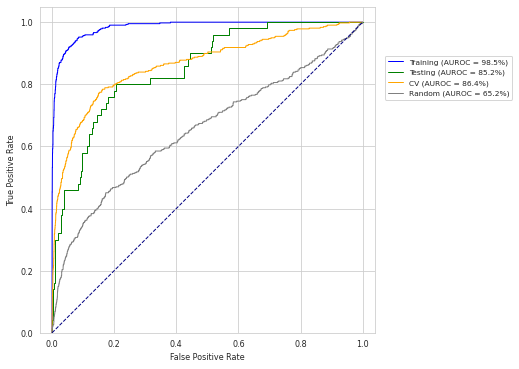

In [400]:
# Plot ROC
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
total_auroc = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]
if shuffled:
    metrics_list += [('Random', metrics_shuffled)]

for label, metrics in metrics_list:

    roc_df = metrics['roc_df']
    plt.plot(roc_df.fpr, roc_df.tpr,
             label='{} (AUROC = {:.1%})'.format(label, metrics['auroc']),
             linewidth=1, c=colors[idx])
    total_auroc[label] = metrics['auroc']
    idx += 1

plt.axis('equal')
plt.plot([0, 1], [0, 1], color='navy', linewidth=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=8)
plt.ylabel('True Positive Rate', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)

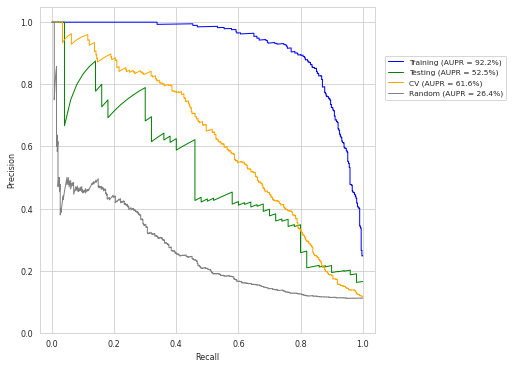

In [401]:
# Plot PR
sns.set_style("whitegrid")
plt.figure(figsize=(6, 6))
total_aupr = {}
colors = ['blue', 'green', 'orange', 'grey']
idx = 0

metrics_list = [('Training', metrics_train), ('Testing', metrics_test),
                ('CV', metrics_cv)]
if shuffled:
    metrics_list += [('Random', metrics_shuffled)]

for label, metrics in metrics_list:
    pr_df = metrics['pr_df']
    plt.plot(pr_df.recall, pr_df.precision,
             label='{} (AUPR = {:.1%})'.format(label, metrics['aupr']),
             linewidth=1, c=colors[idx])
    total_aupr[label] = metrics['aupr']
    idx += 1

plt.axis('equal')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall', fontsize=8)
plt.ylabel('Precision', fontsize=8)
plt.title('')
plt.tick_params(labelsize=8)
lgd = plt.legend(bbox_to_anchor=(1.03, 0.85),
                 loc=2,
                 borderaxespad=0.,
                 fontsize=7.5)